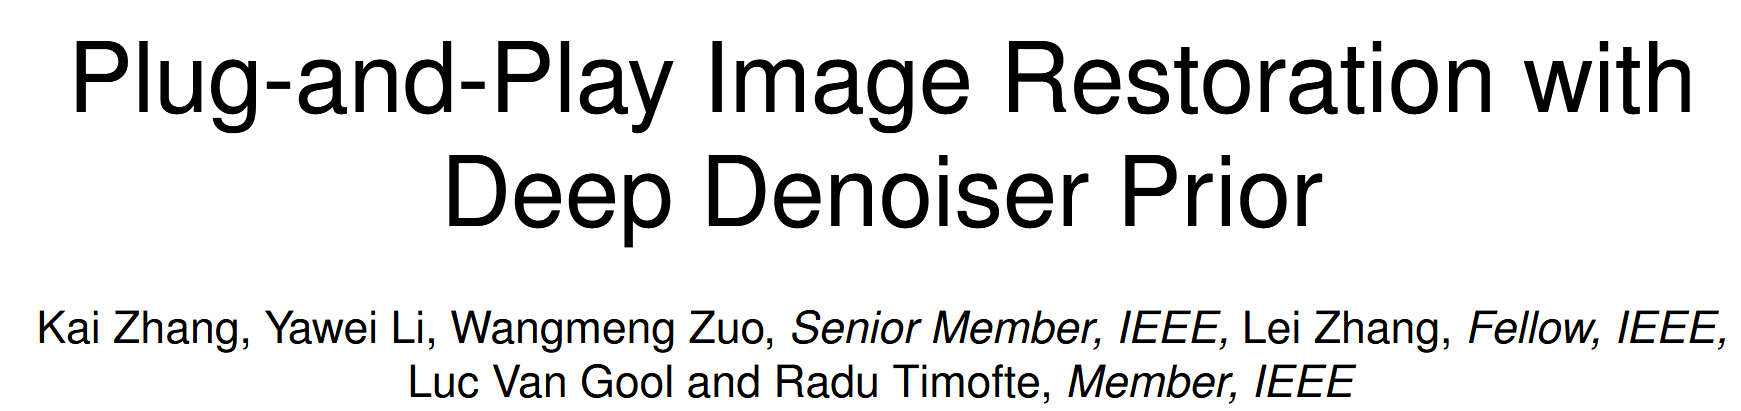


## Background

Image restoration is a fundamental problem in computer vision and computational imaging. The goal is to recover a high-quality image $\mathbf{x}$ from its degraded observation $\mathbf{y}$, which may be blurred, noisy, downsampled, or compressed.

A standard Bayesian approach is to perform Maximum A Posteriori (MAP) estimation:

\begin{equation}
\hat{\mathbf{x}} = \arg\max_{\mathbf{x}} \log p(\mathbf{y} \mid \mathbf{x}) + \log p(\mathbf{x})
\tag{1}
\end{equation}

Assuming additive Gaussian noise, i.e.,
\begin{equation} 
\mathbf{y} = \mathcal{T}(\mathbf{x}) + \mathbf{n}, \quad \mathbf{n} \sim \mathcal{N}(0, \sigma^2 \mathbf{I})
\end{equation}

the likelihood becomes:

\begin{equation}
p(\mathbf{y}|\mathbf{x}) = \frac{1}{Z} \exp\left(-\frac{1}{2\sigma^2} \|\mathbf{y} - \mathcal{T}(\mathbf{x})\|^2 \right)
\tag{2}
\end{equation}

Taking the negative log of Equation (1) and substituting Equation (2) leads to the following optimization formulation:

\begin{equation}
\hat{\mathbf{x}} = \arg\min_{\mathbf{x}} \frac{1}{2\sigma^2} \| \mathbf{y} - \mathcal{T}(\mathbf{x}) \|^2 + \lambda \mathcal{R}(\mathbf{x})
\tag{3}
\end{equation}


### Review: Maximum A Posteriori (MAP)

Maximum a posteriori (MAP) estimation solves:

\begin{equation}
\hat{\mathbf{x}} = \arg\max_{\mathbf{x}} \log p(\mathbf{y} \mid \mathbf{x}) + \log p(\mathbf{x})
\tag{1}
\end{equation}

- $p(\mathbf{y} \mid \mathbf{x})$: likelihood (data consistency)
- $p(\mathbf{x})$: prior (natural image constraint)

---

#### 🍵 Example: Guessing a Drink

You are given a glass of unknown liquid $\mathbf{y}$ and asked to guess what original drink $\mathbf{x}$ it came from.

1. **Likelihood**: If $\mathbf{x}$ were tea, would adding water or ice turn it into what you taste now?
2. **Prior**: Is $\mathbf{x}$ a drink people normally make (e.g., tea, not soy sauce)?

MAP chooses the $\mathbf{x}$ that both:
- Could realistically lead to $\mathbf{y}$ (via degradation)
- Is itself likely to be a valid original (natural prior)

---

In this paper, the **forward model** $T(x)$ is a deterministic function (like blurring, downsampling, etc). But in **Bayesian inference**, we always deal with **uncertainty**, so we represent the **observation model** probabilistically:

\begin{equation}
y = T(x) + \text{noise}
\quad \Rightarrow \quad p(y|x)
\end{equation}

Even though $T(x)$ is deterministic, **the noise is random**, so the output $y$ becomes a **random variable**. That’s why we use **likelihood functions** $p(y|x)$ — they describe the **probability distribution of observed data** given the true signal $x$.

So:  
- **Forward model = deterministic process**  
- **Likelihood = probabilistic model of observations**, accounting for noise

Authors use $p(y|x)$ because it naturally connects optimization with **probability theory**, and allows us to apply Bayesian tools like MAP, variational inference, or even sampling (in generative models).



## The Core Idea

The Plug-and-Play (PnP) framework, first proposed by Venkatakrishnan et al. [1], makes a simple but powerful observation: instead of specifying an explicit prior $\mathcal{R}(\mathbf{x})$, we can **plug in a denoiser** as a black-box prior. In essence:
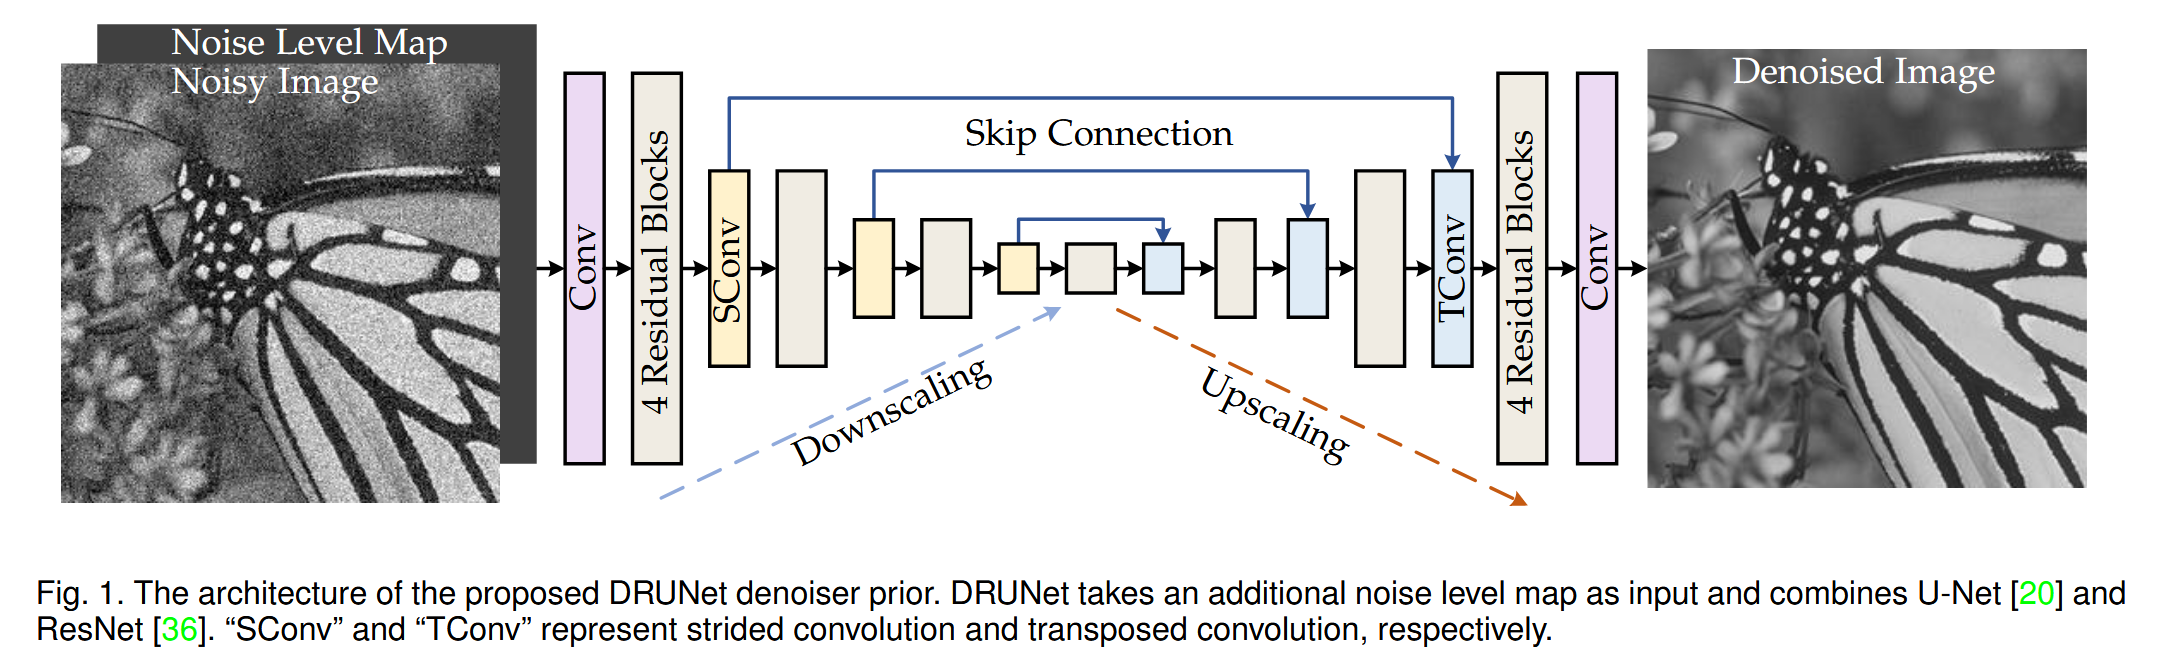
> Replace the proximal operator of the prior term with a denoising function.

This enables using modern CNN-based denoisers, such as DnCNN or DRUNet, which are trained on clean/noisy image pairs, as implicit priors.

The optimization problem becomes decoupled into two subproblems:

**Data fidelity step:**
\begin{equation}
\mathbf{x}^{(k)} = \arg\min_{\mathbf{x}} \| \mathbf{y} - \mathcal{T}(\mathbf{x}) \|^2 + \mu \| \mathbf{x} - \mathbf{z}^{(k-1)} \|^2
\tag{4a}
\end{equation}

**Denoising step (Prior step):**
\begin{equation}
\mathbf{z}^{(k)} = \arg\min_{\mathbf{z}} \frac{1}{2} \left( \frac{\lambda}{\mu} \right)^2 \| \mathbf{z} - \mathbf{x}^{(k)} \|^2 + \mathcal{R}(\mathbf{z})
\tag{4b}
\end{equation}

This is the core of the Half-Quadratic Splitting (HQS) formulation. Here, $k$ denotes the iteration index of the optimization process. In PnP, the second step is not solved explicitly; rather, we perform:

\begin{equation}
\mathbf{z}^{(k)} = \text{Denoiser}(\mathbf{x}^{(k)}, \sigma_k)
\tag{5}
\end{equation}



## Contributions

Traditional priors (e.g., total variation, wavelet sparsity) are often hand-crafted and limited in expressive power. In contrast, deep denoisers trained on large datasets can implicitly learn complex natural image statistics.

However, deep denoisers are not explicitly derived from any energy function $\mathcal{R}(\cdot)$, so integrating them into principled optimization algorithms is non-trivial. PnP solves this by letting us "plug" them into classical iterative solvers.

### Contributions of This Paper [3]

- Reformulated the HQS algorithm with modern deep denoisers.
- Proposed DRUNet as a high-performance, bias-free denoiser.
- Unified traditional MAP estimation and data-driven denoising priors.
- Demonstrated strong empirical results on classical image restoration tasks.



## References

[1] Venkatakrishnan, S. V., Bouman, C. A., & Wohlberg, B. (2013). Plug-and-play priors for model based reconstruction. *GlobalSIP*.

[2] Zhang, K., Zuo, W., & Zhang, L. (2017). Beyond a Gaussian denoiser: Residual learning of deep CNN for image denoising. *TIP*.

[3] Zhang, K., Zuo, W., Gu, S., & Zhang, L. (2021). Plug-and-Play Image Restoration with Deep Denoiser Prior. *TPAMI*.

[4] Romano, Y., Elad, M., & Milanfar, P. (2017). The little engine that could: Regularization by denoising (RED). *SIAM Imaging Sciences*.


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import dppp  # Your custom module (should include blur, psnr, lpips_alex, hqs_super_resolve, etc.)
import matplotlib.pyplot as plt

# Automatically select device
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print("Using device:", device)

# Dataset class to load images from a folder
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir):
        self.image_paths = sorted([
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
        ])
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img)

# Smart image display function
def smart_imshow(tensor, title=None):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu()
    if tensor.dim() == 3:
        if tensor.shape[0] in [1, 3]:  # [C, H, W]
            tensor = tensor.permute(1, 2, 0).numpy()
        else:  # Already in [H, W, C]
            tensor = tensor.numpy()
    elif tensor.dim() == 2:
        tensor = tensor.numpy()
    if tensor.ndim == 2 or (tensor.ndim == 3 and tensor.shape[2] == 1):
        plt.imshow(tensor.squeeze(), cmap='gray')
    else:
        plt.imshow(tensor)
    if title:
        plt.title(title)
    plt.axis("off")

# Path to image dataset
data_root = "/home/xqgao/2025/MIT/Datasets/CBSD68/original"
dataset = ImageFolderDataset(data_root)

# Load one image and move it to device
image = dataset[0].unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

# Prepare a blur kernel
kernel = dppp.conv2D_filter_rgb(dppp.NB_DEBLURRING_LEVIN_KERNELS[0]).to(torch.float32).to(device)

# Simulate degraded image (blur + Gaussian noise)
noise_stddev = 0.04
degraded = dppp.blur(image, kernel, noise_stddev=noise_stddev)

# Load denoiser model (ensure it runs on the same device)
denoiser = dppp.load_denoiser(device=device)

# Deconvolution via HQS (Plug-and-Play image restoration)
reconstructed = dppp.hqs_super_resolve(
    degraded=degraded,
    image=image,
    sr_factor=1,
    denoiser=denoiser,
    max_denoiser_stddev=0.2,
    kernel=None,           # Set to None to use iterative solver
    callbacks=[],          # Optional hooks for visualization or logging
)

### Explanation of `hqs_super_resolve` function

This function implements a Plug-and-Play (PnP) super-resolution algorithm based on the Half-Quadratic Splitting (HQS) framework. The optimization problem is split into two sub-problems that are solved alternately in an iterative manner.

---

We aim to solve the following HQS formulation:

\begin{equation}
\mathbf{x}^{(k)} = \arg\min_{\mathbf{x}} \| \mathbf{y} - \mathcal{T}(\mathbf{x}) \|^2 + \mu \| \mathbf{x} - \mathbf{z}^{(k-1)} \|^2
\tag{4a}
\end{equation}

```python
# Data consistency step
x = data_solution(x, rhos[step])
```

---

**Denoising step (Prior step):**

\begin{equation}
\mathbf{z}^{(k)} = \arg\min_{\mathbf{z}} \frac{1}{2} \left( \frac{\lambda}{\mu} \right)^2 \| \mathbf{z} - \mathbf{x}^{(k)} \|^2 + \mathcal{R}(\mathbf{z})
\tag{4b}
\end{equation}

This is the core of the Half-Quadratic Splitting (HQS) formulation. Here, $k$ denotes the iteration index of the optimization process. In PnP, the second step is not solved explicitly; rather, we perform:

\begin{equation}
\mathbf{z}^{(k)} = \text{Denoiser}(\mathbf{x}^{(k)}, \sigma_k)
\tag{5}
\end{equation}

```python
# Denoising step (Plug-and-Play prior)
sigma_map = torch.full((B, 1, H, W), sigmas[step], dtype=x.dtype, device=x.device)
x_input = torch.cat([x, sigma_map], dim=1)
x = denoiser(x_input)
```

---

### Data consistency step, the first solution: `_data_solution_iterative`

This function approximates the solution to Eq. (4a) using iterative back-projection:

```python
def _data_solution_iterative(
    x, alpha, degraded, resize_fn, scale_factor, num_steps=30, step_size=1.5, mode='bicubic'
):
    for _ in range(num_steps):
        # Downsample
        if resize_fn is not None:
            x_down = resize_fn(x, scale_factor, upsample=False)
        else:
            B, C, H, W = x.shape
            h, w = H // scale_factor, W // scale_factor
            x_down = F.interpolate(x, size=(h, w), mode=mode, align_corners=False)

        # Residual
        data_err = degraded - x_down

        # Upsample
        if resize_fn is not None:
            data_err_up = resize_fn(data_err, scale_factor, upsample=True)
        else:
            B, C, H, W = x.shape
            data_err_up = F.interpolate(data_err, size=(H, W), mode=mode, align_corners=False)

        # Update
        x = x + step_size * data_err_up

    return x
```

This method is simple and generic, relying on forward and backward projections using bicubic interpolation or a custom resize function.

---

### Data consistency step, the second solution: `_data_solution_closed_form`

When a known degradation kernel is available, the following closed-form solution in the Fourier domain is used:

```python
def _data_solution_closed_form(x, alpha, FB, FBC, F2B, FBFy, scale_factor):
    alpha_complex = torch.tensor(alpha, dtype=torch.complex64, device=x.device)
    x_cf = x  # shape [B, C, H, W]

    FR = FBFy + _rfft2d(alpha * x_cf)

    B, C, H, W = x_cf.shape
    FBR = _splits(FB * FR, scale_factor, W).mean(dim=-1)
    invW = _splits(F2B, scale_factor, W).mean(dim=-1)

    invWBR = FBR / (invW + alpha_complex)
    invWBR_tiled = torch.tile(invWBR, (1, 1, scale_factor, scale_factor))[..., :FBC.shape[-1]]

    FCBinvWBR = FBC * invWBR_tiled
    FX = (FR - FCBinvWBR) / alpha_complex
    x_est = _irfft2d(FX, like=x_cf)

    return x_est
```

This method uses efficient convolution via the FFT to solve the data term in one shot, which is significantly faster when the degradation model is known.

---

### Denoising step

Instead of solving the prior optimization problem explicitly, we define:

```python
sigma_map = torch.full((B, 1, H, W), sigmas[step], dtype=x.dtype, device=x.device)
x_input = torch.cat([x, sigma_map], dim=1)
x = denoiser(x_input)
```

This corresponds to Eq. (5), where the denoiser is conditioned on the current noise level $\sigma_k$.

---
